In [29]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Statistics

include("../helpers.jl");
include("../scalers.jl")
include("../stats.jl");

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_raw_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_raw_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_raw_df, y_raw_df = readjsonsfromdirectory(target_directory, x_raw_df, y_raw_df);

In [4]:
# some cuts
abnormally_high_rfq_length = 220. # OBJ3
abnormally_high_longitudinal_emittance = 0.2 # OBJ4
abnormally_high_x_emittance = 0.08 # OBJ5
abnormally_high_y_emittance = 0.08 # OBJ6

non_outlier_conditional = (y_raw_df[:, "OBJ3"] .<= abnormally_high_rfq_length) .&
    (y_raw_df[:, "OBJ4"] .<= abnormally_high_longitudinal_emittance) .&
    (y_raw_df[:, "OBJ5"] .<= abnormally_high_x_emittance) .&
    (y_raw_df[:, "OBJ6"] .<= abnormally_high_y_emittance)

# process data
x_outliers_df = x_raw_df[(!).(non_outlier_conditional), :];
y_outliers_df = y_raw_df[(!).(non_outlier_conditional), :];

x_df = x_raw_df[non_outlier_conditional, :];
y_df = y_raw_df[non_outlier_conditional, :];

In [5]:
sum((!).(non_outlier_conditional))

717

## Data preprocessing

In [6]:
# scaling data
x_scaled_df = minmaxscaledf(x_df)
x_dynamically_scaled_df = dynamicminmaxscaledf(x_df)
y_scaled_df = minmaxscaledf(y_df)

@assert(all(maximum(y_scaled_df[!, colname]) == 1. for colname in names(y_scaled_df)))
@assert(all(minimum(y_scaled_df[!, colname]) == -1. for colname in names(y_scaled_df)))

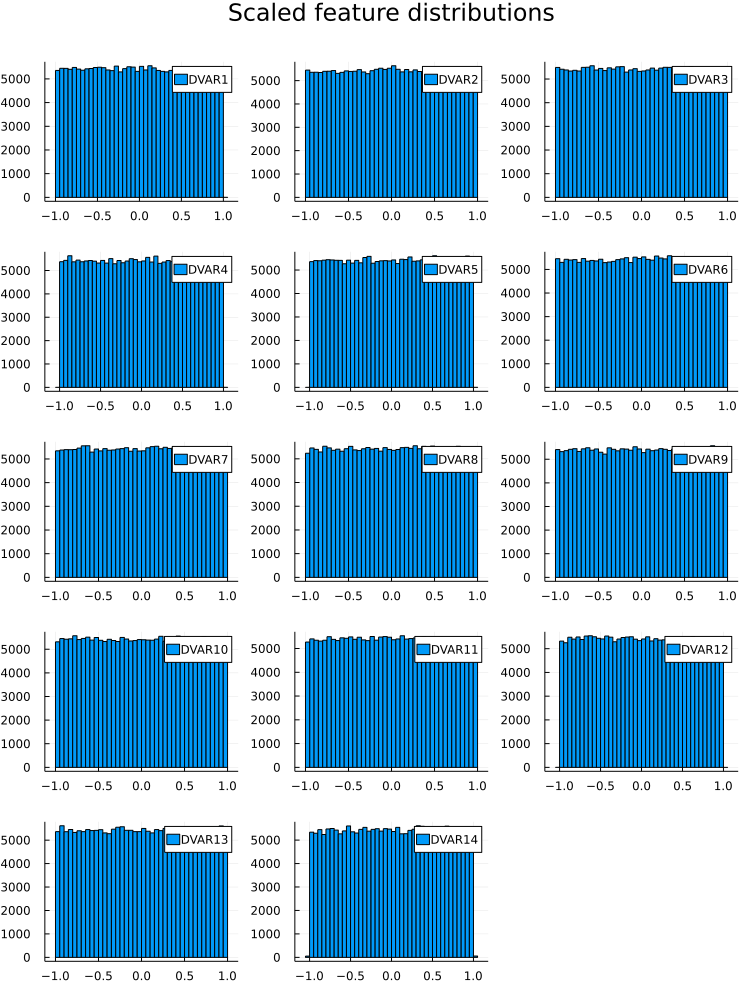

In [7]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_dynamically_scaled_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Scaled feature distributions")

In [8]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];

x_train_decorr_df = x_dynamically_scaled_df[train_indexes, :];
x_test_decorr_df = x_dynamically_scaled_df[test_indexes, :];

y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [9]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
x_train_decorr = Matrix(x_train_decorr_df); x_test_decorr = Matrix(x_test_decorr_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [10]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [11]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 150, x->relu(x)),
        Dense(150, 150, x->relu(x)),
        Dense(150, 150, x->relu(x)),
        Dense(150, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [12]:
# organizing data into batches
batch_size = 32
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [13]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM(0.0001)
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 1250
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=77.08588565979153
epoch 2, loss=65.26798627432436
epoch 3, loss=58.87673844629899
epoch 4, loss=56.38157864101231
epoch 5, loss=55.261568455956876
epoch 6, loss=52.57287326781079
epoch 7, loss=52.73022603103891
epoch 8, loss=51.61557955900207
epoch 9, loss=50.59984946157783
epoch 10, loss=50.700587537139654
epoch 11, loss=49.25444772373885
epoch 12, loss=49.68759249383584
epoch 13, loss=48.94543918641284
epoch 14, loss=48.57458094973117
epoch 15, loss=48.03892794018611
epoch 16, loss=48.21932704281062
epoch 17, loss=48.43842609459534
epoch 18, loss=47.26462516793981
epoch 19, loss=47.25007662829012
epoch 20, loss=47.13935045199469
epoch 21, loss=46.92523673456162
epoch 22, loss=46.61418535746634
epoch 23, loss=46.752958523109555
epoch 24, loss=46.409979169256985
epoch 25, loss=46.39046472404152
epoch 26, loss=46.117843423970044
epoch 27, loss=45.98633229313418
epoch 28, loss=45.79296502796933
epoch 29, loss=45.99528358131647
epoch 30, loss=45.53111539129168
epoch 31, loss

epoch 243, loss=39.96393897244707
epoch 244, loss=39.84322820464149
epoch 245, loss=40.24184297421016
epoch 246, loss=39.85469269682653
epoch 247, loss=40.09565245686099
epoch 248, loss=40.095031393226236
epoch 249, loss=39.87505788728595
epoch 250, loss=39.96499959239736
epoch 251, loss=39.92313171457499
epoch 252, loss=39.96911515761167
epoch 253, loss=39.781882676295936
epoch 254, loss=40.00293469708413
epoch 255, loss=39.96232318691909
epoch 256, loss=40.05218420503661
epoch 257, loss=40.088708157185465
epoch 258, loss=39.673222506418824
epoch 259, loss=40.069677346386015
epoch 260, loss=40.18645567679778
epoch 261, loss=39.977790370583534
epoch 262, loss=39.7495367154479
epoch 263, loss=39.92120049428195
epoch 264, loss=39.75015481794253
epoch 265, loss=39.60949622094631
epoch 266, loss=39.76444769045338
epoch 267, loss=39.89769107638858
epoch 268, loss=39.840298146009445
epoch 269, loss=39.89230582071468
epoch 270, loss=39.64328927267343
epoch 271, loss=39.90785285481252
epoch 27

epoch 483, loss=37.80695526418276
epoch 484, loss=37.83167846198194
epoch 485, loss=38.07565799402073
epoch 486, loss=37.983834500424564
epoch 487, loss=38.2291015945375
epoch 488, loss=38.28069697506726
epoch 489, loss=37.944174602627754
epoch 490, loss=38.16460289619863
epoch 491, loss=37.8489021116402
epoch 492, loss=38.223667938727885
epoch 493, loss=37.73188205296174
epoch 494, loss=37.91760939802043
epoch 495, loss=38.17620190209709
epoch 496, loss=37.81787657109089
epoch 497, loss=37.789239736739546
epoch 498, loss=38.15858329925686
epoch 499, loss=38.19031701912172
epoch 500, loss=37.87348863459192
epoch 501, loss=38.01916959090158
epoch 502, loss=37.87130705756135
epoch 503, loss=38.066636085975915
epoch 504, loss=38.06040233420208
epoch 505, loss=37.83894786727615
epoch 506, loss=37.90125492820516
epoch 507, loss=37.92031642375514
epoch 508, loss=37.8529419710394
epoch 509, loss=37.684955259552225
epoch 510, loss=37.84885776648298
epoch 511, loss=37.716731413966045
epoch 512,

epoch 723, loss=36.584995354292914
epoch 724, loss=36.767910237424076
epoch 725, loss=36.580389434471726
epoch 726, loss=36.80370239098556
epoch 727, loss=36.65438105282374
epoch 728, loss=36.76471633929759
epoch 729, loss=36.49803359829821
epoch 730, loss=36.63826984609477
epoch 731, loss=36.772739115869626
epoch 732, loss=36.62500739120878
epoch 733, loss=36.60440007597208
epoch 734, loss=36.71592228859663
epoch 735, loss=37.07005997910164
epoch 736, loss=36.84609295614064
epoch 737, loss=36.71859032660723
epoch 738, loss=36.61151280789636
epoch 739, loss=36.38210672792047
epoch 740, loss=36.57120828516781
epoch 741, loss=36.68611319898628
epoch 742, loss=36.60436306009069
epoch 743, loss=36.50671244948171
epoch 744, loss=36.286550373071805
epoch 745, loss=36.58283748431131
epoch 746, loss=36.66964885685593
epoch 747, loss=36.83992019039579
epoch 748, loss=36.650813882471994
epoch 749, loss=36.72096190135926
epoch 750, loss=36.74031316651963
epoch 751, loss=36.41613486642018
epoch 75

epoch 963, loss=35.62389529496431
epoch 964, loss=35.927592899650335
epoch 965, loss=35.83659826288931
epoch 966, loss=35.65629828162491
epoch 967, loss=35.720649590017274
epoch 968, loss=35.71467973268591
epoch 969, loss=36.483408838743344
epoch 970, loss=35.50247232359834
epoch 971, loss=35.53327224520035
epoch 972, loss=35.93842042097822
epoch 973, loss=36.4291851753369
epoch 974, loss=36.103673732606694
epoch 975, loss=35.65384252765216
epoch 976, loss=35.35769168892875
epoch 977, loss=35.6333919223398
epoch 978, loss=35.56699039740488
epoch 979, loss=36.01415234524757
epoch 980, loss=35.660086733521894
epoch 981, loss=35.92974840523675
epoch 982, loss=35.944697816390544
epoch 983, loss=35.94256420293823
epoch 984, loss=35.806417579296976
epoch 985, loss=35.68614687863737
epoch 986, loss=35.944345630472526
epoch 987, loss=35.53109746566042
epoch 988, loss=35.37489173747599
epoch 989, loss=35.635742587503046
epoch 990, loss=35.68244916689582
epoch 991, loss=35.869879494654015
epoch 

epoch 1197, loss=35.09808995388448
epoch 1198, loss=34.92882369575091
epoch 1199, loss=34.931754315271974
epoch 1200, loss=35.2061549811624
epoch 1201, loss=35.10905074188486
epoch 1202, loss=35.1610904505942
epoch 1203, loss=35.31098654633388
epoch 1204, loss=35.16533323517069
epoch 1205, loss=35.11545093473978
epoch 1206, loss=34.86807092442177
epoch 1207, loss=35.351300925947726
epoch 1208, loss=34.817061552777886
epoch 1209, loss=35.07258556224406
epoch 1210, loss=35.145179382991046
epoch 1211, loss=35.15103920339607
epoch 1212, loss=35.00134369311854
epoch 1213, loss=35.27217160933651
epoch 1214, loss=35.3812144708354
epoch 1215, loss=34.919973951997235
epoch 1216, loss=35.200001324526966
epoch 1217, loss=35.46888107131235
epoch 1218, loss=34.89041606988758
epoch 1219, loss=35.02497587329708
epoch 1220, loss=34.75842880876735
epoch 1221, loss=34.94816645584069
epoch 1222, loss=35.13551397714764
epoch 1223, loss=35.06575496029109
epoch 1224, loss=35.1364312171936
epoch 1225, loss=3

In [14]:
# organizing data into batches for decorrelated data
data_decorr_loader = Flux.Data.DataLoader((x_train_decorr', y_train'), batchsize=batch_size, shuffle=true);

In [15]:
# defining our model, optimization algorithm and loss function
m_decorr = neuralnetwork()
optimizer = ADAM(0.0001)
loss_decorr(x, y) = Flux.mse(m_decorr(x), y)

# training
training_losses_decorr = Float32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss_decorr, Flux.params(m_decorr), data_decorr_loader, optimizer)
    l = 0.
    for d in data_decorr_loader
        l += loss_decorr(d...)
    end
    println(" loss=$l")
    push!(training_losses_decorr, l)
end

epoch 1, loss=81.15830852652329
epoch 2, loss=67.80033073885018
epoch 3, loss=60.40469955894316
epoch 4, loss=57.825393070613906
epoch 5, loss=54.892047111530076
epoch 6, loss=53.64412980697933
epoch 7, loss=52.339923469827134
epoch 8, loss=52.0071234684844
epoch 9, loss=50.83215845731298
epoch 10, loss=50.22835378978477
epoch 11, loss=50.471192522593554
epoch 12, loss=49.84059904523427
epoch 13, loss=48.769987584289346
epoch 14, loss=48.737478397980006
epoch 15, loss=48.29481694463048
epoch 16, loss=48.47562010461644
epoch 17, loss=47.61417735339207
epoch 18, loss=47.84378363487168
epoch 19, loss=48.49859102752278
epoch 20, loss=47.21015709694068
epoch 21, loss=47.42987135297465
epoch 22, loss=47.574663915788726
epoch 23, loss=46.96745434308492
epoch 24, loss=46.798360791572534
epoch 25, loss=46.125899013778096
epoch 26, loss=46.02067453809321
epoch 27, loss=45.998164767903845
epoch 28, loss=45.815098377692564
epoch 29, loss=46.49660965727316
epoch 30, loss=45.95011718404671
epoch 31,

epoch 243, loss=40.0519125432147
epoch 244, loss=40.31766170013464
epoch 245, loss=40.3460637059386
epoch 246, loss=40.19723210158738
epoch 247, loss=40.07420995857886
epoch 248, loss=40.30840812940339
epoch 249, loss=40.360959401415506
epoch 250, loss=40.037666100278905
epoch 251, loss=39.9896858718088
epoch 252, loss=39.91599453830447
epoch 253, loss=39.93705609075066
epoch 254, loss=40.51586702993296
epoch 255, loss=39.84743210665405
epoch 256, loss=39.98896398346161
epoch 257, loss=40.202634175029424
epoch 258, loss=40.002767480678486
epoch 259, loss=40.0980417597478
epoch 260, loss=40.177620812014624
epoch 261, loss=40.0794622398231
epoch 262, loss=39.84704689578984
epoch 263, loss=39.895233864349855
epoch 264, loss=39.90939783089306
epoch 265, loss=40.005199136119096
epoch 266, loss=40.36228802406746
epoch 267, loss=40.08010821628942
epoch 268, loss=39.77766392177455
epoch 269, loss=40.03492965782066
epoch 270, loss=39.98750038962583
epoch 271, loss=39.854525030299556
epoch 272, 

epoch 483, loss=38.051035135627934
epoch 484, loss=38.23666394268959
epoch 485, loss=37.99401045259268
epoch 486, loss=37.896483193421204
epoch 487, loss=37.8316287054628
epoch 488, loss=38.000389596678986
epoch 489, loss=37.56581839008504
epoch 490, loss=38.20785329722085
epoch 491, loss=38.27469393061345
epoch 492, loss=37.77037282716345
epoch 493, loss=37.840676537011085
epoch 494, loss=37.75396299776488
epoch 495, loss=38.14039666568603
epoch 496, loss=37.596734170804396
epoch 497, loss=37.63768915045672
epoch 498, loss=38.17543849080992
epoch 499, loss=38.14406737423362
epoch 500, loss=37.89613078339555
epoch 501, loss=37.62820946995098
epoch 502, loss=38.56381969859429
epoch 503, loss=37.6315758193084
epoch 504, loss=37.670498018300606
epoch 505, loss=37.64522473247137
epoch 506, loss=37.90685402283357
epoch 507, loss=38.01679926223342
epoch 508, loss=38.34993809035005
epoch 509, loss=37.87854106129429
epoch 510, loss=38.076847809768765
epoch 511, loss=37.69690209801411
epoch 512

epoch 723, loss=36.26255305738304
epoch 724, loss=36.31692483727069
epoch 725, loss=36.58124178033931
epoch 726, loss=36.26628498272096
epoch 727, loss=36.70325004245729
epoch 728, loss=36.305606404978164
epoch 729, loss=36.592397022609205
epoch 730, loss=36.28557838385101
epoch 731, loss=36.31146307144893
epoch 732, loss=36.220370048413166
epoch 733, loss=36.21564223714582
epoch 734, loss=36.28579457818807
epoch 735, loss=36.30543030079829
epoch 736, loss=36.04119220960132
epoch 737, loss=36.60850777222453
epoch 738, loss=36.17563850061408
epoch 739, loss=36.5529399159601
epoch 740, loss=36.51869299077026
epoch 741, loss=36.546890663172896
epoch 742, loss=36.216365868360676
epoch 743, loss=36.342939792299724
epoch 744, loss=35.99486597149568
epoch 745, loss=36.24416191245124
epoch 746, loss=36.52305283868346
epoch 747, loss=36.225690212785146
epoch 748, loss=36.540455474450376
epoch 749, loss=36.39280739663897
epoch 750, loss=36.27362200017489
epoch 751, loss=36.109938544707724
epoch 

epoch 963, loss=35.27858865071297
epoch 964, loss=35.17896025962859
epoch 965, loss=35.549450471709626
epoch 966, loss=35.46413270251704
epoch 967, loss=35.11989641729214
epoch 968, loss=35.7312630385101
epoch 969, loss=35.39543529569478
epoch 970, loss=35.33731403537698
epoch 971, loss=35.117292770605154
epoch 972, loss=35.284678179660396
epoch 973, loss=35.719908554408285
epoch 974, loss=35.499482345940685
epoch 975, loss=35.334183462410856
epoch 976, loss=35.57669496298169
epoch 977, loss=35.202829556514075
epoch 978, loss=35.148992610693874
epoch 979, loss=35.52968341611335
epoch 980, loss=35.14532981628477
epoch 981, loss=35.97962310335339
epoch 982, loss=35.45494276245926
epoch 983, loss=34.97656446391985
epoch 984, loss=35.91013353870881
epoch 985, loss=35.16150845187018
epoch 986, loss=35.175727168863354
epoch 987, loss=35.24306231757936
epoch 988, loss=35.76898717390638
epoch 989, loss=35.12528054833146
epoch 990, loss=35.1507460784237
epoch 991, loss=35.376805374682405
epoch 

epoch 1197, loss=35.270647961388235
epoch 1198, loss=34.48766073263933
epoch 1199, loss=34.641363362497835
epoch 1200, loss=34.93438918684508
epoch 1201, loss=34.71730590652044
epoch 1202, loss=34.72156644773825
epoch 1203, loss=34.65539068901667
epoch 1204, loss=34.497068656231306
epoch 1205, loss=34.7070634301382
epoch 1206, loss=34.76338759317352
epoch 1207, loss=34.374948825446076
epoch 1208, loss=35.14181290755549
epoch 1209, loss=34.57946614125334
epoch 1210, loss=34.58393860179892
epoch 1211, loss=34.43107759471869
epoch 1212, loss=34.770284746603366
epoch 1213, loss=34.5445901139453
epoch 1214, loss=34.534979416659375
epoch 1215, loss=34.45757186388654
epoch 1216, loss=34.604280699736556
epoch 1217, loss=34.38647564353386
epoch 1218, loss=34.76619821889629
epoch 1219, loss=34.60154517070526
epoch 1220, loss=34.85087756066401
epoch 1221, loss=34.482185749396265
epoch 1222, loss=35.002410532432116
epoch 1223, loss=34.508052145802814
epoch 1224, loss=34.42589705552605
epoch 1225, 

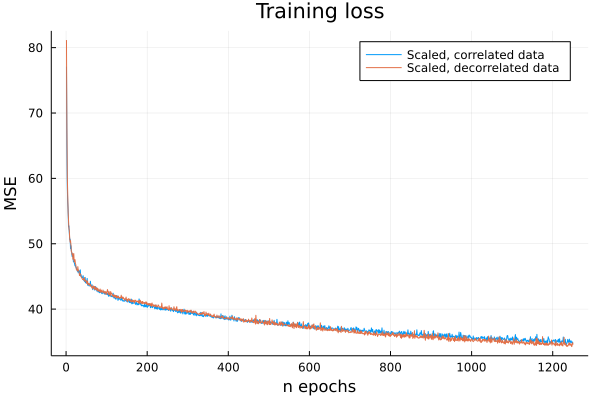

In [16]:
# plot training history
plot(epochs, training_losses;
    title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false,
    label="Scaled, correlated data")
plot!(epochs, training_losses_decorr; legend=true, label="Scaled, decorrelated data")

## Model evaluation

In [17]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [18]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9465098
r2 on test set: 0.92407995


In [19]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 4 methods)

In [20]:
size(x_train, 2)

14

In [21]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.94650537
adjustedr2 on test set: 0.9240554


In [22]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.05460057
mae on test set: 0.062238578


In [23]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.018579725
mae on test set for OBJ1: 0.019880723
mae on training set for OBJ2: 0.07346001
mae on test set for OBJ2: 0.075113416
mae on training set for OBJ3: 0.014375599
mae on test set for OBJ3: 0.0147472825
mae on training set for OBJ4: 0.029009435
mae on test set for OBJ4: 0.031920247
mae on training set for OBJ5: 0.09626298
mae on test set for OBJ5: 0.115989365
mae on training set for OBJ6: 0.09591568
mae on test set for OBJ6: 0.11578041


In [43]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    minmax_fit!(y_scaler, y_df[!, "OBJ$i"])
    
    temp_train_preds_original = minmax_inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = minmax_inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = minmax_inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = minmax_inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for OBJ1: 0.018307832828594498
MAPE on test set for OBJ2: 0.018032869459207356
MAPE on test set for OBJ3: 0.011877000906528908
MAPE on test set for OBJ4: 0.05683239273421094
MAPE on test set for OBJ5: 0.12398760029874907
MAPE on test set for OBJ6: 0.1236075977657889


In [51]:
i = 7
println("true: ", y_test[i, :])
println("predicted: ", y_test_preds[i, :])

true: Float32[0.53536797, 0.5731708, 0.73212147, -0.3816802, -0.25454038, -0.16856074]
predicted: Float32[0.4886259, 0.35174492, 0.71144783, -0.3546645, -0.11279466, -0.11808655]


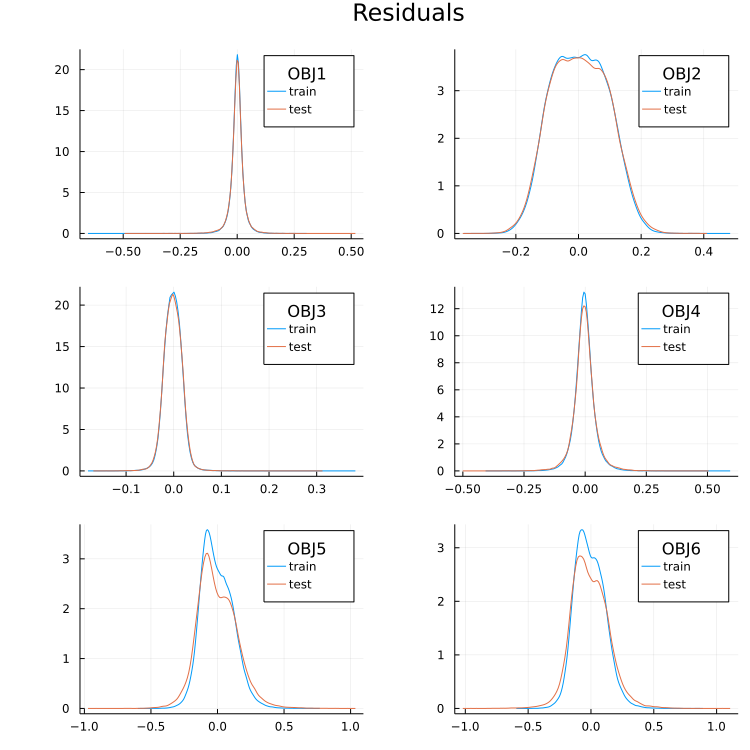

In [24]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

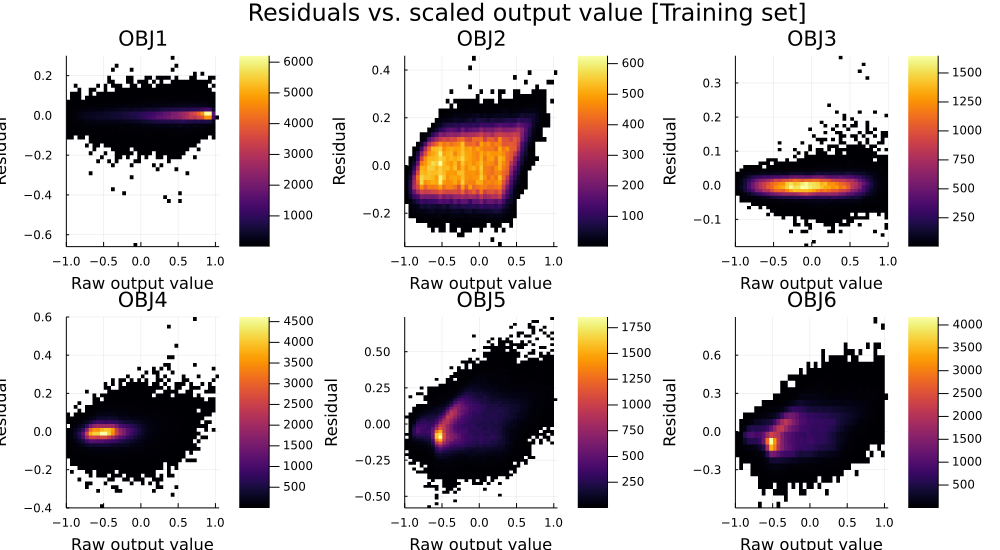

In [25]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

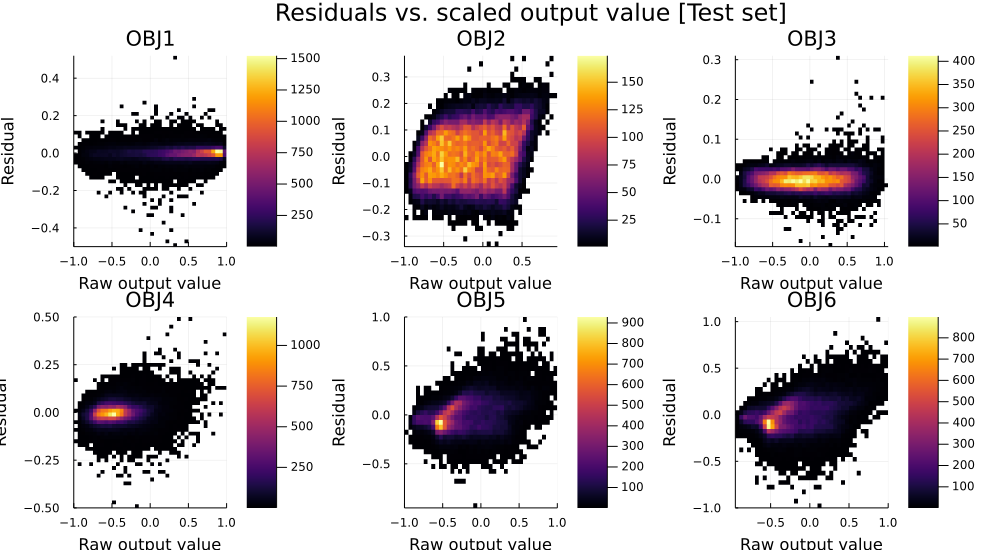

In [26]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")